**Finetuning GPT2**

In [6]:
import numpy as np
import pandas as pd
import torch
import logging
from tqdm import tqdm
import math
import argparse
import os
!git clone https://github.com/huggingface/transformers
!pip install transformers/
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers.optimization import AdamW, get_linear_schedule_with_warmup

Cloning into 'transformers'...
remote: Enumerating objects: 158990, done.
remote: Counting objects: 100% (484/484), done.
remote: Compressing objects: 100% (259/259), done.
remote: Total 158990 (delta 235), reused 332 (delta 176), pack-reused 158506
Receiving objects: 100% (158990/158990), 160.35 MiB | 26.42 MiB/s, done.
Resolving deltas: 100% (119244/119244), done.
Processing ./transformers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.34.0.dev0-py3-none-any.whl size=7683006 sha256=8212687e14cc403640e3907b3dcad375e7780a06f2acb0e87a71e431d70a8683
  Stored in directory: /tmp/pip-ephem-wheel-cache-gd64pfq3/wheels/7c/35/80/e946b22a081210c6642e607ed65b2a5b9a4d9259695ee2caf5
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.33.1
    Uninstalling transformers-4.33.1:
      Successf

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--seed', type=int, default=88888)
parser.add_argument("--model_name", default="gpt2-medium", type=str)
parser.add_argument("--max_seq_length", default=512, type=int)
parser.add_argument("--train_batch_size", default=4, type=int)
parser.add_argument("--valid_batch_size", default=4, type=int)
parser.add_argument("--num_train_epochs", default=4, type=int)
parser.add_argument("--warmup", default=0.1, type=float)
parser.add_argument("--learning_rate", default=5e-5, type=float)

args, _ = parser.parse_known_args()

In [8]:
excel_file = '/content/IDEST_database.xlsx'
idest_df = pd.read_excel(excel_file)
selected_cols = ['text_english', 'tags']
df_selected = idest_df[selected_cols]
df_selected['tags'] = df_selected['tags'].str.replace(';', ' and')
df_selected

<ipython-input-8-e35a78a4daaa>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['tags'] = df_selected['tags'].str.replace(';', ' and')


,text_english,tags
0,"It’s a Friday night, and I’m leaving home for ...",driving
1,I arrive home from a party and sit in front of...,hair
2,It’s an ordinary weekly meeting at my workplac...,work and meeting
3,"It’s a summer day, and I’m on a hiking trip. I...",hiking and nature
4,I’m standing near the edge of the stage in the...,public presentation
...,...,...
245,The only problem we had with this new house th...,family and accident
246,Selim was my childhood friend. We were very cl...,friend and mental illness
247,I have three dogs and two cats. I and five ani...,pets and noises
248,Barbecue is not something we do often or somet...,family


In [4]:
def combinetext(prompt, story):
    prompts=prompt
    stories=story
    assert len(prompts)==len(stories)
    combine=[]
    for i in range(len(prompts)):
        combine.append('From the first-person perspective, write an emotional narrative with maximum 200 words about: ' + prompts[i].rstrip()+' <sep> '+" ".join(stories[i].split()[:300]))
    return combine

def cleanpunctuation(s):
    s=s.replace(' '+'n\'t','n\'t')
    s=s.replace(' '+'\'s','\'s')
    s=s.replace(' '+'\'re','\'re')
    s=s.replace(' '+'\'ve','\'ve')
    s=s.replace(' '+'\'ll','\'ll')
    s=s.replace(' '+'\'am','\'am')
    s=s.replace(' '+'\'m','\'m')
    s=s.replace(' '+'\' m','\'m')
    s=s.replace(' '+'\'m','\'m')
    s=s.replace(' '+'\' ve','\'ve')
    s=s.replace(' '+'\' s','\'s')
    s=s.replace('<newline>','\n')
    return s

In [5]:
fullData=combinetext(df_selected['tags'], df_selected['text_english'])
fullData=list(map(cleanpunctuation,fullData))

In [6]:
fullData

['From the first-person perspective, write an emotional narrative with maximum 200 words about: driving <sep> It’s a Friday night, and I’m leaving home for the gym, which is located next to a shopping mall, so I park my car in the mall’s lot. I’m in a good mood because I can start my weekend more relaxed after a workout. After my workout, the lot is now full of cars. I walk to my car and notice families all around me with their children and shopping carts. I’m glad I did my shopping for the weekend yesterday and avoided long lines at the supermarket. I can just go home and start my weekend. I reach my car, open the door and get behind the wheel. I throw my gym bag onto the front seat and take out my cell phone. I want to check messages and incoming calls before I start driving. After checking my phone, I start my car, glance into the rearview mirror and drive out of the parking lot to go home.',
 'From the first-person perspective, write an emotional narrative with maximum 200 words ab

In [7]:
model = GPT2LMHeadModel.from_pretrained('gpt2-medium')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')
tokenizer.pad_token=tokenizer.eos_token
def create_labels(inputs):
    labels=[]
    for ids,attention_mask in zip(inputs['input_ids'],inputs['attention_mask']):
        label=ids.copy()
        real_len=sum(attention_mask)
        padding_len=len(attention_mask)-sum(attention_mask)
        label[:]=label[:real_len]+[-100]*padding_len
        labels.append(label)
    inputs['labels']=labels


In [8]:
class StoryDataset:
    def __init__(self, inputs):
        self.ids = inputs['input_ids']
        self.attention_mask = inputs['attention_mask']
        self.labels=inputs['labels']

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, item):

        return [torch.tensor(self.ids[item], dtype=torch.long),
                torch.tensor(self.attention_mask[item], dtype=torch.long),
                torch.tensor(self.labels[item], dtype=torch.long)]

In [9]:
num_train_epochs = args.num_train_epochs

weight_decay=0
learning_rate=args.learning_rate
adam_epsilon=1e-8
warmup_steps=500
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": weight_decay,
    },
    {
        "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

print("***** Running training *****")
#print("  Total_num_training_step = {}".format(total_num_training_steps))
print("  Num Epochs = {}".format(num_train_epochs))
#print(f"  Train_batch_size per device = {train_batch_size}")
#print(f"  Valid_batch_size per device = {valid_batch_size}")
model.to('cuda')
for fold, (train_idx, val_idx) in enumerate(kfold.split(fullData)):
  # Print the current fold number
  print(f"Fold {fold+1}/5")
  print(type(train_idx))
  print(type(fullData))
  train_text = [fullData[i] for i in train_idx]
  valid_text = [fullData[i] for i in val_idx]

  inputs_train = tokenizer(train_text, padding=True,truncation=True,max_length=args.max_seq_length)
  inputs_valid=tokenizer(valid_text, padding=True,truncation=True,max_length=args.max_seq_length)

  create_labels(inputs_train)
  create_labels(inputs_valid)
  train_batch_size=args.train_batch_size
  valid_batch_size=args.valid_batch_size
  traindata=StoryDataset(inputs_train)
  train_dataloader = torch.utils.data.DataLoader(
    traindata,
    shuffle=False,
    batch_size=train_batch_size)

  validdata=StoryDataset(inputs_valid)
  valid_dataloader = torch.utils.data.DataLoader(
    validdata,
    shuffle=False,
    batch_size=valid_batch_size)
  training_steps_per_epoch=len(train_dataloader)
  total_num_training_steps = int(training_steps_per_epoch*num_train_epochs)

  scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_num_training_steps
  )

  for epoch in range(num_train_epochs):
      print(f"Start epoch{epoch+1} of {num_train_epochs}")
      train_loss=0
      epoch_iterator = tqdm(train_dataloader,desc='Iteration')
      model.train()
      model.zero_grad()
      for _, inputs in enumerate(epoch_iterator):
          d1,d2,d3=inputs
          d1=d1.to('cuda')
          d2=d2.to('cuda')
          d3=d3.to('cuda')
          output = model(input_ids=d1, attention_mask=d2,labels=d3)
          batch_loss=output[0]
          batch_loss.backward()
          optimizer.step()
          scheduler.step()
          model.zero_grad()
          train_loss+=batch_loss.item()
          epoch_iterator.set_description('(batch loss=%g)' % batch_loss.item())
          del batch_loss
      print(f'Average train loss per example={train_loss/training_steps_per_epoch} in epoch{epoch+1}')
      print(f'Starting evaluate after epoch {epoch+1}')
      eval_loss=[]
      model.eval()
      for inputs in tqdm(valid_dataloader, desc="eval"):
          d1,d2,d3=inputs
          d1=d1.to('cuda')
          d2=d2.to('cuda')
          d3=d3.to('cuda')
          with torch.no_grad():
              output = model(input_ids=d1, attention_mask=d2,labels=d3)
              batch_loss=output[0]
          eval_loss+=[batch_loss.cpu().item()]
          del batch_loss
      eval_loss=np.mean(eval_loss)
      perplexity=math.exp(eval_loss)
      print(f'Average valid loss per example={eval_loss} in epoch{epoch+1}')
      print(f'Perplextiy for valid dataset in epoch{epoch+1} is {perplexity}')

***** Running training *****
  Num Epochs = 4
Fold 1/5
<class 'numpy.ndarray'>
<class 'list'>
Start epoch1 of 4


(batch loss=3.10717): 100%|██████████| 50/50 [00:57<00:00,  1.16s/it]


Average train loss per example=3.2446872425079345 in epoch1
Starting evaluate after epoch 1


eval: 100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Average valid loss per example=2.9617257668421817 in epoch1
Perplextiy for valid dataset in epoch1 is 19.331304309114877
Start epoch2 of 4


(batch loss=2.81498): 100%|██████████| 50/50 [00:58<00:00,  1.17s/it]


Average train loss per example=2.885419716835022 in epoch2
Starting evaluate after epoch 2


eval: 100%|██████████| 13/13 [00:04<00:00,  3.00it/s]


Average valid loss per example=2.7013312119704027 in epoch2
Perplextiy for valid dataset in epoch2 is 14.899552992088312
Start epoch3 of 4


(batch loss=2.74056): 100%|██████████| 50/50 [00:58<00:00,  1.17s/it]


Average train loss per example=2.6836939811706544 in epoch3
Starting evaluate after epoch 3


eval: 100%|██████████| 13/13 [00:04<00:00,  3.03it/s]


Average valid loss per example=2.6720843131725607 in epoch3
Perplextiy for valid dataset in epoch3 is 14.470097998828914
Start epoch4 of 4


(batch loss=2.64901): 100%|██████████| 50/50 [00:58<00:00,  1.17s/it]


Average train loss per example=2.574224147796631 in epoch4
Starting evaluate after epoch 4


eval: 100%|██████████| 13/13 [00:04<00:00,  3.09it/s]


Average valid loss per example=2.6709368228912354 in epoch4
Perplextiy for valid dataset in epoch4 is 14.453503224997187
Fold 2/5
<class 'numpy.ndarray'>
<class 'list'>
Start epoch1 of 4


(batch loss=2.62609): 100%|██████████| 50/50 [00:58<00:00,  1.16s/it]


Average train loss per example=2.5436416816711427 in epoch1
Starting evaluate after epoch 1


eval: 100%|██████████| 13/13 [00:04<00:00,  3.09it/s]


Average valid loss per example=2.342933324667124 in epoch1
Perplextiy for valid dataset in epoch1 is 10.411732805840833
Start epoch2 of 4


(batch loss=2.57868): 100%|██████████| 50/50 [00:58<00:00,  1.16s/it]


Average train loss per example=2.5201954460144043 in epoch2
Starting evaluate after epoch 2


eval: 100%|██████████| 13/13 [00:04<00:00,  3.06it/s]


Average valid loss per example=2.346177623822139 in epoch2
Perplextiy for valid dataset in epoch2 is 10.445566435316572
Start epoch3 of 4


(batch loss=2.52148): 100%|██████████| 50/50 [00:58<00:00,  1.16s/it]


Average train loss per example=2.458579807281494 in epoch3
Starting evaluate after epoch 3


eval: 100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


Average valid loss per example=2.3538314562577467 in epoch3
Perplextiy for valid dataset in epoch3 is 10.525821789235772
Start epoch4 of 4


(batch loss=2.42948): 100%|██████████| 50/50 [00:58<00:00,  1.17s/it]


Average train loss per example=2.3675065541267397 in epoch4
Starting evaluate after epoch 4


eval: 100%|██████████| 13/13 [00:04<00:00,  2.97it/s]


Average valid loss per example=2.365826441691472 in epoch4
Perplextiy for valid dataset in epoch4 is 10.65283913092651
Fold 3/5
<class 'numpy.ndarray'>
<class 'list'>
Start epoch1 of 4


(batch loss=2.49592): 100%|██████████| 50/50 [00:54<00:00,  1.08s/it]


Average train loss per example=2.3188513779640196 in epoch1
Starting evaluate after epoch 1


eval: 100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


Average valid loss per example=2.1009081418697653 in epoch1
Perplextiy for valid dataset in epoch1 is 8.173589321809049
Start epoch2 of 4


(batch loss=2.41348): 100%|██████████| 50/50 [00:54<00:00,  1.09s/it]


Average train loss per example=2.293374752998352 in epoch2
Starting evaluate after epoch 2


eval: 100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


Average valid loss per example=2.108711526944087 in epoch2
Perplextiy for valid dataset in epoch2 is 8.237620491744835
Start epoch3 of 4


(batch loss=2.40368): 100%|██████████| 50/50 [00:54<00:00,  1.08s/it]


Average train loss per example=2.2341250228881835 in epoch3
Starting evaluate after epoch 3


eval: 100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


Average valid loss per example=2.1232077525212216 in epoch3
Perplextiy for valid dataset in epoch3 is 8.357904623189569
Start epoch4 of 4


(batch loss=2.30871): 100%|██████████| 50/50 [00:54<00:00,  1.09s/it]


Average train loss per example=2.152664768695831 in epoch4
Starting evaluate after epoch 4


eval: 100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


Average valid loss per example=2.1422469982734094 in epoch4
Perplextiy for valid dataset in epoch4 is 8.518557323478937
Fold 4/5
<class 'numpy.ndarray'>
<class 'list'>
Start epoch1 of 4


(batch loss=2.24114): 100%|██████████| 50/50 [00:58<00:00,  1.16s/it]


Average train loss per example=2.110801990032196 in epoch1
Starting evaluate after epoch 1


eval: 100%|██████████| 13/13 [00:03<00:00,  3.33it/s]


Average valid loss per example=1.8036370094005878 in epoch1
Perplextiy for valid dataset in epoch1 is 6.071690149539686
Start epoch2 of 4


(batch loss=2.23002): 100%|██████████| 50/50 [00:57<00:00,  1.16s/it]


Average train loss per example=2.087110090255737 in epoch2
Starting evaluate after epoch 2


eval: 100%|██████████| 13/13 [00:03<00:00,  3.59it/s]


Average valid loss per example=1.8137622888271625 in epoch2
Perplextiy for valid dataset in epoch2 is 6.133480000752985
Start epoch3 of 4


(batch loss=2.15342): 100%|██████████| 50/50 [00:57<00:00,  1.15s/it]


Average train loss per example=2.0331148862838746 in epoch3
Starting evaluate after epoch 3


eval: 100%|██████████| 13/13 [00:03<00:00,  3.60it/s]


Average valid loss per example=1.8299559996678278 in epoch3
Perplextiy for valid dataset in epoch3 is 6.233612371475424
Start epoch4 of 4


(batch loss=2.07212): 100%|██████████| 50/50 [00:57<00:00,  1.15s/it]


Average train loss per example=1.9479325962066651 in epoch4
Starting evaluate after epoch 4


eval: 100%|██████████| 13/13 [00:03<00:00,  3.59it/s]


Average valid loss per example=1.854704526754526 in epoch4
Perplextiy for valid dataset in epoch4 is 6.389809953779034
Fold 5/5
<class 'numpy.ndarray'>
<class 'list'>
Start epoch1 of 4


(batch loss=2.27673): 100%|██████████| 50/50 [00:57<00:00,  1.15s/it]


Average train loss per example=1.8920659589767457 in epoch1
Starting evaluate after epoch 1


eval: 100%|██████████| 13/13 [00:04<00:00,  3.11it/s]


Average valid loss per example=1.5872415762681227 in epoch1
Perplextiy for valid dataset in epoch1 is 4.890240949836848
Start epoch2 of 4


(batch loss=2.2018): 100%|██████████| 50/50 [00:57<00:00,  1.15s/it]


Average train loss per example=1.8623445415496827 in epoch2
Starting evaluate after epoch 2


eval: 100%|██████████| 13/13 [00:04<00:00,  3.12it/s]


Average valid loss per example=1.5993755230536828 in epoch2
Perplextiy for valid dataset in epoch2 is 4.94994033540135
Start epoch3 of 4


(batch loss=2.13551): 100%|██████████| 50/50 [00:57<00:00,  1.16s/it]


Average train loss per example=1.8148992586135864 in epoch3
Starting evaluate after epoch 3


eval: 100%|██████████| 13/13 [00:04<00:00,  3.11it/s]


Average valid loss per example=1.618099992091839 in epoch3
Perplextiy for valid dataset in epoch3 is 5.043498520131838
Start epoch4 of 4


(batch loss=2.04538): 100%|██████████| 50/50 [00:57<00:00,  1.16s/it]


Average train loss per example=1.7226743173599244 in epoch4
Starting evaluate after epoch 4


eval: 100%|██████████| 13/13 [00:04<00:00,  3.12it/s]

Average valid loss per example=1.637492766747108 in epoch4
Perplextiy for valid dataset in epoch4 is 5.142260489537207


In [11]:
def generate_story(prompt,target,k=0,p=0.9,output_length=200,temperature=0.7,num_return_sequences=3,repetition_penalty=1.0):
    print("====prompt====\n")
    print(prompt+"\n")
    print('====target story is as below===\n')
    print(target+"\n")
    encoded_prompt = tokenizer.encode(prompt, add_special_tokens=False, return_tensors="pt")
    model.to('cpu')
    model.eval()
    output_sequences = model.generate(
        input_ids=encoded_prompt,
        max_length=output_length,
        temperature=temperature,
        top_k=k,
        top_p=p,
        repetition_penalty=repetition_penalty,
        do_sample=True,
        num_return_sequences=num_return_sequences
    )
    if len(output_sequences.shape) > 2:
        output_sequences.squeeze_()
    for generated_sequence_idx, generated_sequence in enumerate(output_sequences):
        print("=== GENERATED SEQUENCE {} ===".format(generated_sequence_idx + 1))
        generated_sequence = generated_sequence.tolist()
        # Decode text
        text = tokenizer.decode(generated_sequence, clean_up_tokenization_spaces=True)
        # Remove all text after eos token
        text = text[: text.find(tokenizer.eos_token)]
        print(text)


In [12]:
prompt='From the first-person perspective, write an emotional narrative with maximum 200 words about: planets'
target=fullData[118][fullData[118].find('<sep>')+5:]
generate_story(prompt,target)

====prompt====

From the first-person perspective, write an emotional narrative with maximum 200 words about: planets

====target story is as below===

 I still remember the first weeks after the birth very well. I couldn't stop looking at him. He was so perfect, with his little button nose and his big wide eyes, his little feet and tiny toes. I was sure he was the prettiest and sweetest baby in the whole world. When I lay next to him and he slept, I couldn't take my eyes off him. I watched him lying there, so peacefully, sucking on his pacifier. And I listened to his soft, even breath. I couldn't get enough of cuddling up tightly with him, being very close to him. I had to cry often because it was so indescribably beautiful. I've never felt such a deep love for anyone before as I do for him. He is my life, my everything. Just the thought that something might happen to him turns my stomach. I'm so incredibly happy that I get to be his mother.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


=== GENERATED SEQUENCE 1 ===
From the first-person perspective, write an emotional narrative with maximum 200 words about: planets and birth <sep> I was about to go to bed. When I woke up, I was completely surprised. I looked at the sky and saw a beautiful blue sky. I felt so happy. I went to the mirror and saw my beautiful face. My little self had finally appeared! I was so happy! I was so happy. I was so happy. I was so happy. I was so happy. I was so happy. I was so happy. I was so happy. I was so happy. I was so happy. I was so happy. I was so happy. I was so happy. I was so happy. I was so happy. I was so happy. I was so happy. I was so happy. I was so happy. I was so happy. I was so happy. I was so happy. I was so happy. I was so happy. I was s
=== GENERATED SEQUENCE 2 ===
From the first-person perspective, write an emotional narrative with maximum 200 words about: planets and space <sep> The first thing I noticed when I stepped on the surface of another world was how beautiful i

In [13]:
def generate_story_inportmodel(prompt,k=0,p=0.9,output_length=219,temperature=0.7,num_return_sequences=1,repetition_penalty=1.0):
    print("====prompt====\n")
    print(prompt+"\n")
    encoded_prompt = tokenizer.encode(prompt, add_special_tokens=False, return_tensors="pt")
    model.to('cpu')
    model.eval()
    output_sequences = model.generate(
        input_ids=encoded_prompt,
        max_length=output_length,
        temperature=temperature,
        top_k=k,
        top_p=p,
        repetition_penalty=repetition_penalty,
        do_sample=True,
        num_return_sequences=num_return_sequences
    )
    if len(output_sequences.shape) > 2:
        output_sequences.squeeze_()
    for generated_sequence_idx, generated_sequence in enumerate(output_sequences):
        print("=== GENERATED SEQUENCE {} ===".format(generated_sequence_idx + 1))
        generated_sequence = generated_sequence.tolist()
        # Decode text
        text = tokenizer.decode(generated_sequence, clean_up_tokenization_spaces=True)
        # Remove all text after eos token
        text = text[: text.find(tokenizer.eos_token)]
        print(text)
        return text

In [14]:
from google.colab import files

In [17]:
gpt2_df = pd.DataFrame(columns=["tag","story"])
for tag in tags:
#for tag in df_selected['tags']:
  prompt='From the first-person perspective, write an emotional narrative with maximum 200 words about: ' + tag
  story = generate_story_inportmodel(prompt)
  gpt2_df = gpt2_df.append({"tag": tag,"story": story}, ignore_index=True)

# Save the updated DataFrame to the CSV file
csv_file_path = "GPT2-new-finetune.csv"
gpt2_df.to_csv(csv_file_path, index=False)

# Download the CSV file to your local machine
files.download(csv_file_path)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


====prompt====

From the first-person perspective, write an emotional narrative with maximum 200 words about: home



<ipython-input-17-78c9c10d0b8f>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gpt2_df = gpt2_df.append({"tag": tag,"story": story}, ignore_index=True)
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


=== GENERATED SEQUENCE 1 ===
From the first-person perspective, write an emotional narrative with maximum 200 words about: home and family and pet <sep> I am lying on a bed in my parents' house, which is quite small, especially compared to the rest of the house. The ceiling is covered diamond-shaped, and the only light comes from a narrow window on the upper floor. The only sounds that come through are the soft whimpers of the cat and the wagging tail of the dog which is lying on my lap. The only thing that irritates me is the sound of the cat's purring, which annoys me even more. I am not used to it, and I am not used to humans either. I only know cats from stories and movies. I like the smell of cat urine and the sound of the cat purring, and I like it when it is happy. However, the purring of the dog is not for me. It makes me sneeze. When I am lying on my bed, the only sound that is audible is the rustling of the sheet
====prompt====

From the first-person perspective, write an emo

<ipython-input-17-78c9c10d0b8f>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gpt2_df = gpt2_df.append({"tag": tag,"story": story}, ignore_index=True)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
# preprocess the stories by removing the begining sentence of the prompt
import re
for i, story in enumerate(gpt2_df['story']):
  new_story = re.sub(r".*?<sep>", "", story)
  gpt2_df.loc[i, "story"] = new_story
print(gpt2_df)

    tag                                              story
0  home   I am lying on a bed in my parents' house, whi...
1  love   It’s been years since I last went out, but I ...


**sentiment analysis**

Sentiment analysis with sliding window approach

IDEST data example

In [47]:
#data preprocessing
story = idest_df['text_english']
sentiment_map = { 1: 'Constant',  2: 'Tragedy', 3 : 'Rags-to-riches',  4 : 'Man-in-a-hole ',  5 :'Icarus',  6 : 'Oedipus',  7 : 'Cinderella', 8 : 'No clear story' }
# Reverse the key-value pairs in the dictionary
sentiment_map = {str(key): value for key, value in sentiment_map.items()}
idest_df['StoryType'] = idest_df['StoryType'].astype(str).replace(sentiment_map)

#tokenize the stories using NLTK
import nltk
stories = []
input_sentences = []
nltk.download('punkt')

for item in story:
  stories.append(item)
from nltk.tokenize import sent_tokenize

for story in stories:
  input_sentences.append(sent_tokenize(story))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#sentiment analysis using the sliding window approach
! pip install torch
sentiment_data = []

# Convert sentences and labels to numpy arrays

for story_index, story in enumerate(input_sentences):
    sentences = list(story)

    # Define window size and stride
    window_size = 2
    stride = 1

    # Create sliding windows of sentences
    windows = [sentences[i:i + window_size] for i in range(0, len(sentences) - window_size + 1, stride)]

    # Tokenize and encode the windows
    encoded_windows = []
    for window in windows:
        encoded = tokenizer.encode_plus(
            window,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        encoded_windows.append(encoded)

    # Perform inference on the windows
    model.eval()
    sentiment_labels = []
    sentiment_probabilities = []

    with torch.no_grad():
      for encoded_window in encoded_windows:
        input_ids = encoded_window['input_ids']
        attention_mask = encoded_window['attention_mask']

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_label = torch.argmax(logits).item()

        probabilities = torch.softmax(logits, dim=1)
        predicted_probability = probabilities[0][1].item()


        # Map the predicted label to the corresponding sentiment category
        sentiment_labels.append(predicted_label)

        # Store the sentiment probability in the list
        sentiment_probabilities.append(predicted_probability)

    # Store the data in a dictionary
    for i, window in enumerate(windows[:min(len(sentiment_labels), len(windows))]):
        sentiment_data.append({
            'Story': f"Story {story_index + 1}",
            'Sentences': ' '.join(window),
            'Sentiment Label': sentiment_labels[i],
            'Sentiment Probability': sentiment_probabilities[i]
        })

# Convert the data to a pandas DataFrame for tabular representation
human_story_sentiment = pd.DataFrame(sentiment_data)

# Print the DataFrame
print(len(human_story_sentiment))

In [57]:
# Group by 'Story' and calculate the average 'Sentiment Probability'
grouped_human = human_story_sentiment.groupby('Story')['Sentiment Probability'].mean().reset_index()

# Set 'Sentiment Label' to 1 if 'Sentiment Probability' is >= 0.5 , 0 otherwise
grouped_human['Sentiment Label'] = (grouped_human['Sentiment Probability'] >= 0.5).astype(int)

In [58]:
# Merge 'human' with 'grouped_human' based on 'Story' to get 'Sentiment Label' information for each story
merged_human = human_story_sentiment.merge(grouped_human[['Story', 'Sentiment Label']], on='Story', how='left')

# Filter the entries with 'Sentiment Label' equal to 1
stories_with_sentiment_label_1 = merged_human[merged_human['Sentiment Label_y'].eq(1)]
stories_with_sentiment_label_0 = merged_human[merged_human['Sentiment Label_y'].eq(0)]


In [59]:
##positive stories
stories_with_sentiment_label_1['Sliding Window'] = stories_with_sentiment_label_1.groupby('Story').cumcount() + 1
stories_with_sentiment_label_1

<ipython-input-59-0881e8e4e8c1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stories_with_sentiment_label_1['Sliding Window'] = stories_with_sentiment_label_1.groupby('Story').cumcount() + 1


,Story,Sentences,Sentiment Label_x,Sentiment Probability,Sentiment Label_y,Sliding Window
0,Story 1,"It’s a Friday night, and I’m leaving home for ...",1,0.998880,1,1
1,Story 1,I’m in a good mood because I can start my week...,1,0.999706,1,2
2,Story 1,"After my workout, the lot is now full of cars....",1,0.998332,1,3
3,Story 1,I walk to my car and notice families all aroun...,1,0.990078,1,4
4,Story 1,I’m glad I did my shopping for the weekend yes...,0,0.042066,1,5
5,Story 1,I can just go home and start my weekend. I rea...,1,0.993792,1,6
6,Story 1,"I reach my car, open the door and get behind t...",0,0.048993,1,7
7,Story 1,I throw my gym bag onto the front seat and tak...,0,0.013982,1,8
8,Story 1,I want to check messages and incoming calls be...,0,0.242464,1,9


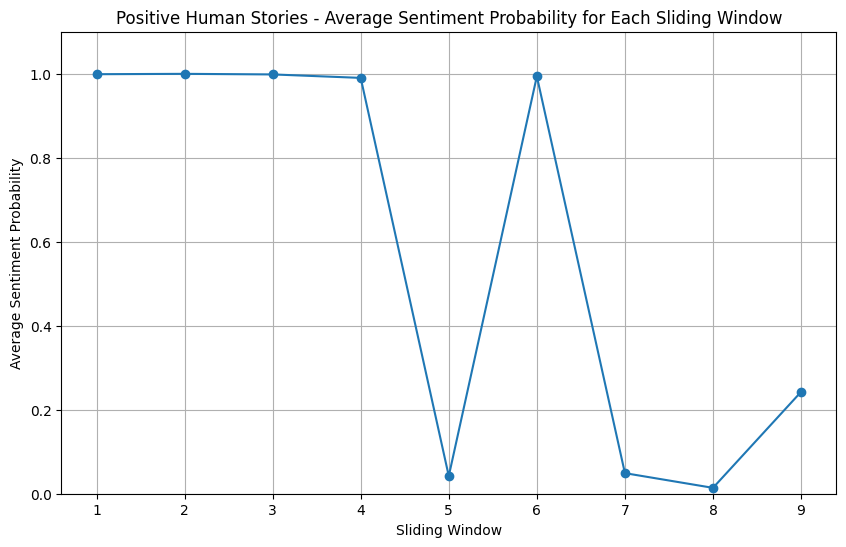

In [60]:
import matplotlib.pyplot as plt

# Group by 'Sliding Window' and calculate the average 'Sentiment Probability' for each window
average_probability_by_window = stories_with_sentiment_label_1.groupby('Sliding Window')['Sentiment Probability'].mean()

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(average_probability_by_window.index, average_probability_by_window.values, marker='o', linestyle='-')
plt.xlabel('Sliding Window')
plt.ylabel('Average Sentiment Probability')
plt.title('Positive Human Stories - Average Sentiment Probability for Each Sliding Window')
plt.grid(True)


plt.ylim(0, 1.1)

plt.show()

In [61]:
#negative stories
stories_with_sentiment_label_0['Sliding Window'] = stories_with_sentiment_label_0.groupby('Story').cumcount() + 1
stories_with_sentiment_label_0

<ipython-input-61-c523d4c7d2fa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stories_with_sentiment_label_0['Sliding Window'] = stories_with_sentiment_label_0.groupby('Story').cumcount() + 1


,Story,Sentences,Sentiment Label_x,Sentiment Probability,Sentiment Label_y,Sliding Window
9,Story 2,I arrive home from a party and sit in front of...,1,0.999269,0,1
10,Story 2,I went to a hairdresser before the party and r...,0,0.056091,0,2
11,Story 2,They used a lot of hairspray at the hairdresse...,0,0.002164,0,3
12,Story 2,They also back-combed my hair into an elegant ...,0,0.010708,0,4
13,Story 2,It would be a shame to undo such a fantastic h...,0,0.002539,0,5
14,Story 2,"I know that in the morning, it would be even m...",0,0.015280,0,6
15,Story 2,"I brush my hair carefully, starting from the s...",1,0.905517,0,7
16,Story 2,I hold my hair from the roots while I work thr...,0,0.006956,0,8
17,Story 2,"This way, brushing hurts less. When I have wor...",0,0.004043,0,9
18,Story 2,When I have worked through my hair on the side...,1,0.875100,0,10


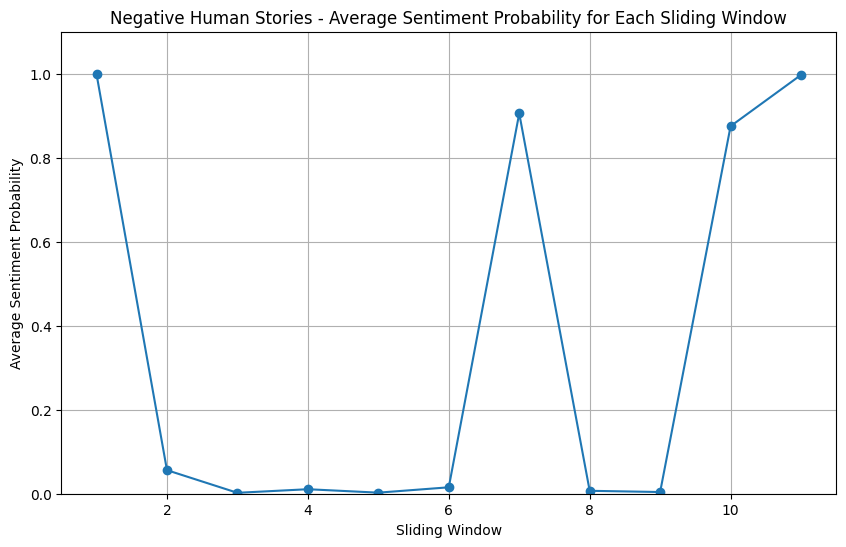

In [62]:
# Group by 'Sliding Window' and calculate the average 'Sentiment Probability' for each window
average_probability_by_window = stories_with_sentiment_label_0.groupby('Sliding Window')['Sentiment Probability'].mean()

plt.figure(figsize=(10, 6))
plt.plot(average_probability_by_window.index, average_probability_by_window.values, marker='o', linestyle='-')
plt.xlabel('Sliding Window')
plt.ylabel('Average Sentiment Probability')
plt.title('Negative Human Stories - Average Sentiment Probability for Each Sliding Window')
plt.grid(True)

plt.ylim(0, 1.1)

plt.show()


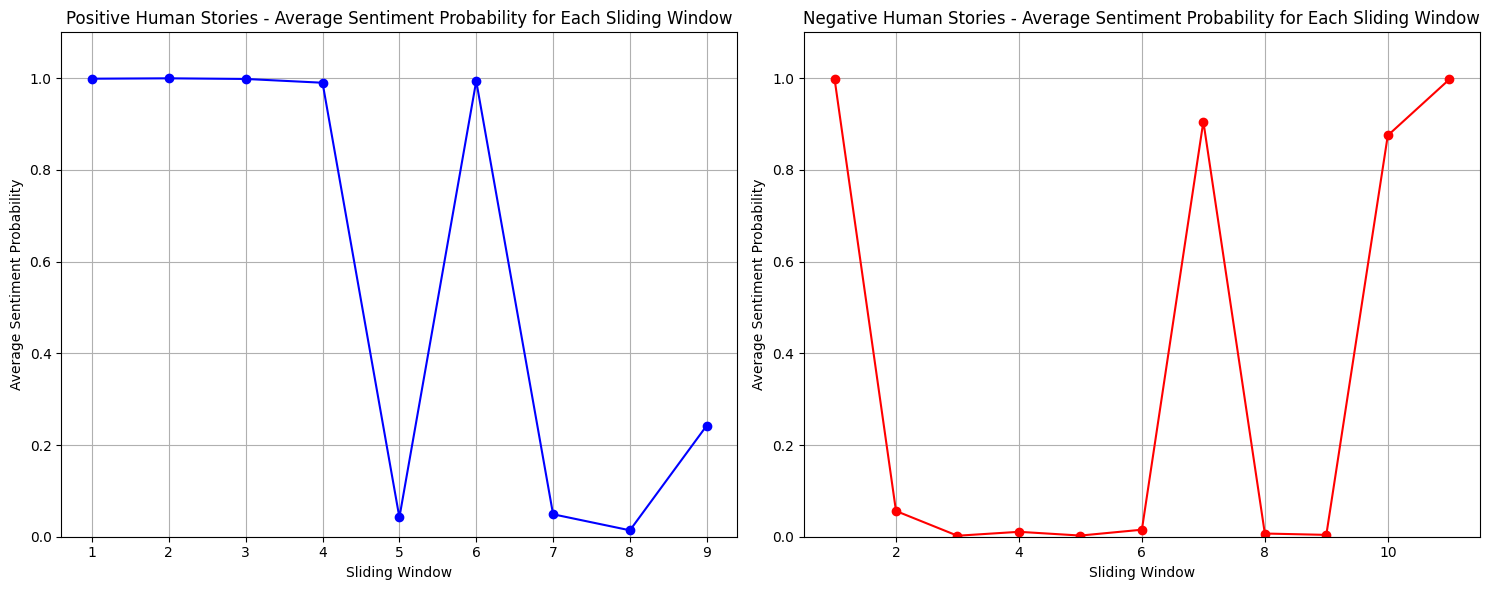

In [63]:
# Group by 'Sliding Window' and calculate the average 'Sentiment Probability' for each window
average_probability_positive = stories_with_sentiment_label_1.groupby('Sliding Window')['Sentiment Probability'].mean()
average_probability_negative = stories_with_sentiment_label_0.groupby('Sliding Window')['Sentiment Probability'].mean()

# Plot with two subplots side by side
plt.figure(figsize=(15, 6))

# Plot for positive stories
plt.subplot(1, 2, 1)
plt.plot(average_probability_positive.index, average_probability_positive.values, marker='o', linestyle='-',color='blue')
plt.xlabel('Sliding Window')
plt.ylabel('Average Sentiment Probability')
plt.title('Positive Human Stories - Average Sentiment Probability for Each Sliding Window')
plt.grid(True)
plt.ylim(0, 1.1)

# Plot for negative stories
plt.subplot(1, 2, 2)
plt.plot(average_probability_negative.index, average_probability_negative.values, marker='o', linestyle='-',color='red')
plt.xlabel('Sliding Window')
plt.ylabel('Average Sentiment Probability')
plt.title('Negative Human Stories - Average Sentiment Probability for Each Sliding Window')
plt.grid(True)
plt.ylim(0, 1.1)

plt.tight_layout()

plt.show()


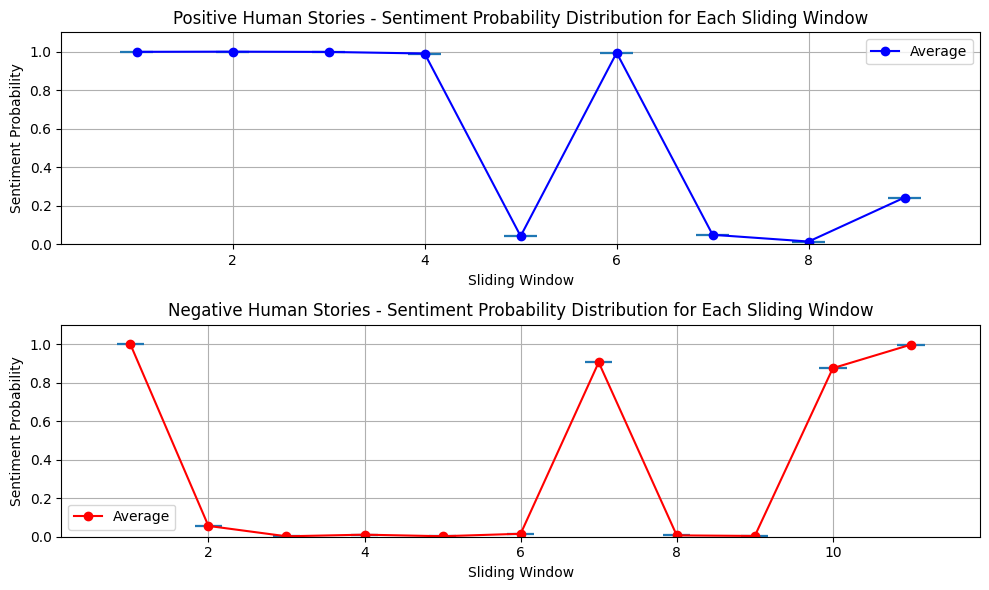

In [65]:
# Group by 'Sliding Window' and collect the 'Sentiment Probability' for each window as lists
data_positive = stories_with_sentiment_label_1.groupby('Sliding Window')['Sentiment Probability'].apply(list)
data_negative = stories_with_sentiment_label_0.groupby('Sliding Window')['Sentiment Probability'].apply(list)

# Convert the index to a 1-dimensional array using .to_numpy() or .values
positions_positive = average_probability_positive.index.to_numpy()
positions_negative = average_probability_negative.index.to_numpy()

# Create the violin plot for positive stories
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.violinplot(data_positive, positions=positions_positive, showmedians=True, vert=True, widths=0.7, points=100)
plt.plot(average_probability_positive.index, average_probability_positive.values, marker='o', linestyle='-', color='blue', label='Average')
plt.xlabel('Sliding Window')
plt.ylabel('Sentiment Probability')
plt.title('Positive Human Stories - Sentiment Probability Distribution for Each Sliding Window')
plt.grid(True)
plt.ylim(0, 1.1)
plt.legend()

# Create the violin plot for negative stories
plt.subplot(2, 1, 2)  # 2 rows, 1 column, plot 2 (bottom)
plt.violinplot(data_negative, positions=positions_negative, showmedians=True, vert=True, widths=0.7, points=100)
plt.plot(average_probability_negative.index, average_probability_negative.values, marker='o', linestyle='-', color='red', label='Average')
plt.xlabel('Sliding Window')
plt.ylabel('Sentiment Probability')
plt.title('Negative Human Stories - Sentiment Probability Distribution for Each Sliding Window')
plt.grid(True)
plt.ylim(0, 1.1)
plt.legend()
plt.tight_layout()
plt.show()
